# Assignment 2 : Group 6 
## Team Members
* Vuyo Fortune Mathe
* Roan Palm
* Henko Meyer

###  Classification Algorithm to predict if a company will go bankrupt 
---



In [1]:
# Import all nessecary libraries 
import gzip 
import json 
import pickle 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split # Training and Testing Split Library
from sklearn.preprocessing import StandardScaler # Import library for Feature Scaling
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Loading and preparing data 


*   Import Dataset



In [2]:
# Open the gzipped JSON file
with gzip.open('poland-bankruptcy-data-2009.json.gz', 'rb') as f:
    # Read the contents of the file
    file_contents = f.read()

# Decode the file contents and parse the JSON data
dataset = json.loads(file_contents.decode('utf-8'))





*   Data preparing



In [3]:
dataset.keys() #Get keys from Json format data

dict_keys(['schema', 'data', 'metadata'])

In [4]:
len(dataset['data']) #Number of instances

9977

In [5]:
len(dataset['data'][0]) #Number of features

66

In [6]:
type(dataset)
df = pd.DataFrame().from_dict(dataset['data']).set_index('company_id')
df.head() 

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


## Data Exploration

<Axes: xlabel='bankrupt'>

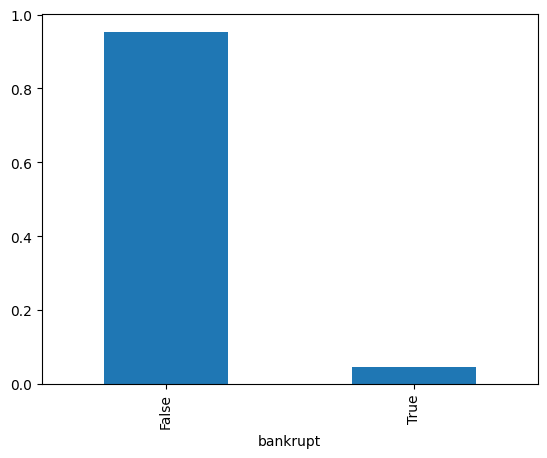

In [7]:
df.bankrupt.value_counts(normalize=True).plot(kind='bar')

In [8]:
percent_missing = df.isnull().sum() / df.shape[0] * 100.00
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
feat_37,feat_37,44.883231
feat_21,feat_21,7.737797
feat_27,feat_27,6.665330
feat_60,feat_60,5.632956
feat_45,feat_45,5.622933
...,...,...
feat_10,feat_10,0.000000
feat_7,feat_7,0.000000
feat_6,feat_6,0.000000
feat_3,feat_3,0.000000


In [9]:
df.describe()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
count,9977.000000,9977.000000,9977.000000,9960.000000,9.952000e+03,9977.000000,9977.000000,9964.000000,9974.000000,9977.000000,...,9.977000e+03,9935.000000,9977.000000,9948.000000,9977.000000,9.415000e+03,9961.00000,9.935000e+03,9960.000000,9765.000000
mean,0.052688,0.623634,0.088614,10.067323,-1.412557e+03,-0.124340,0.065407,16.757657,1.820532,0.362319,...,6.771696e+03,-0.561651,-0.028476,3.976806,1.486227,5.938426e+02,13.62412,1.364510e+02,9.034435,36.291450
std,0.662816,6.590734,6.584543,537.128699,1.216712e+05,7.145680,0.666113,673.845491,7.771473,6.592272,...,6.121491e+04,57.438557,19.134737,195.155108,79.262784,3.812344e+04,73.22837,2.666901e+04,31.773572,438.506192
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,...,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.59030,-2.336500e+06,-0.000156,-0.000102
25%,0.000700,0.255280,0.016341,1.036150,-5.266650e+01,0.000000,0.002265,0.430778,1.011100,0.296990,...,1.304300e+01,0.005136,0.007051,0.875850,0.000000,5.532000e+00,4.49120,4.101200e+01,3.049300,2.003100
50%,0.042731,0.465920,0.197570,1.600650,1.495950e+00,0.000000,0.050661,1.104150,1.197300,0.513340,...,8.874800e+02,0.051546,0.106550,0.953130,0.003356,9.933700e+00,6.67050,7.093200e+01,5.116700,4.031400
75%,0.123140,0.690060,0.415680,2.950525,5.601725e+01,0.071759,0.141700,2.827425,2.044550,0.723920,...,4.363300e+03,0.129640,0.271860,0.995923,0.249600,2.077800e+01,10.58400,1.187050e+02,8.846400,9.574000
max,52.652000,480.730000,17.708000,53433.000000,6.854400e+05,45.533000,52.652000,53432.000000,740.440000,11.837000,...,3.380500e+06,293.150000,552.640000,18118.000000,7617.300000,3.660200e+06,4246.70000,1.073500e+06,1974.500000,21499.000000


In [10]:
# Drop null values
df = df.dropna()

# Display the DataFrame after dropping null values
print("\nDataFrame after dropping null values:")
print(df)


DataFrame after dropping null values:
              feat_1    feat_2    feat_3     feat_4   feat_5    feat_6   
company_id                                                               
1           0.174190  0.412990  0.143710    1.34800  -28.982  0.603830  \
5           0.188290  0.415040  0.342310    1.92790  -58.274  0.000000   
7           0.115030  0.036659  0.923450  112.63000   55.580  0.000000   
8           0.009832  0.670660  0.135460    1.23930 -107.730 -0.001401   
12          0.083519  0.402860  0.583800    2.69400   35.966  0.638970   
...              ...       ...       ...        ...      ...       ...   
10477       0.003603  0.824060 -0.049051    0.89208 -111.350  0.000000   
10491       0.180780  1.014800 -0.118940    0.86624  -61.124 -7.664900   
10494      -0.019241  0.698810  0.050157    1.25360  -12.669  0.000000   
10496       0.062089  0.768410 -0.188140    0.64101  -39.505  0.000000   
10503      -0.001775  0.947800  0.003729    1.00450  -50.221  0.000000   

# 2. Train-Test-Split

In [11]:
target = "bankrupt"
X = df.drop(columns=target)
Y = df[target]

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (4658, 64)
Y shape: (4658,)


## Standardize the features

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Split Data 

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) 
print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", Y_test.shape)

X_train shape: (3726, 64)
y_train shape: (3726,)
X_test shape: (932, 64)
y_test shape: (932,)


# 3. Resampling Technique

In [15]:
over_Sampler = RandomOverSampler(random_state=42)


X_train_over, Y_train_over = over_Sampler.fit_resample(X_train, Y_train)



### Plot the labels on a bar graph

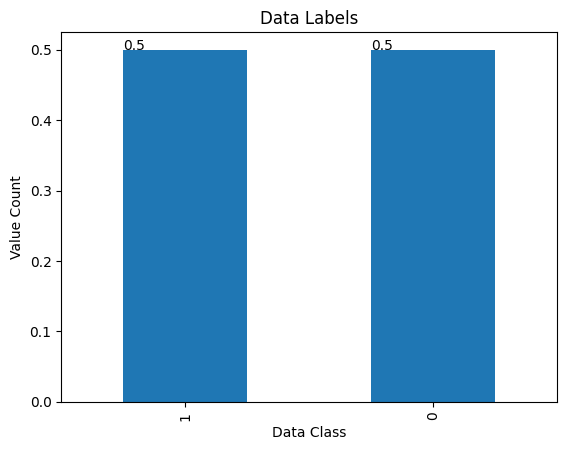

In [ ]:
# Convert the numpy array to pandas series
Y_train_over_series = pd.Series(Y_train_over)

# Get value counts and store it
value_counts = Y_train_over_series.value_counts(normalize=True)

# Create the bar plot
ax = value_counts.plot(kind='bar')

# Add labels to each bar
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)))


plt.title("Data Labels")
plt.xlabel("Data Class")
plt.ylabel("Value Count")
plt.show()

In [ ]:
# Generate a sample classification dataset
X, Y = make_classification(n_samples=1000, n_features=10, random_state=42)
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
# Create a Gradient Boosting Classifier with default hyperparameters
gb_classifier = GradientBoostingClassifier()
# Train the classifier on the training set
gb_classifier.fit(X_train, Y_train)
# Make predictions on the testing set
Y_pred = gb_classifier.predict(X_test)
# Evaluate the accuracy of the classifier
accuracy = gb_classifier.score(X_test, Y_test)
print("Accuracy:", accuracy)


Accuracy: 0.892


# 4. Hyper-Parameter Tuning

In [ ]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
# Create a random forest classifier
rf = RandomForestClassifier()
# Create a grid search object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # Use 5-fold cross-validation
    n_jobs=-1  # Use all available CPU cores
)
# Fit the grid search object to the data
grid_search.fit(X, Y)
# Print the best hyperparameters found
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 10}


# 5. Model Evaluation

## Evaluation 

In [ ]:
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, average='weighted')
recall = recall_score(Y_test, Y_pred, average='weighted')
f1 = f1_score(Y_test, Y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)

Accuracy:  0.892
Precision:  0.8988929303278689
Recall:  0.892
F1-Score:  0.8922335827232092


# 6. Feature Importance analysis 

In [ ]:
# Compute feature importances and sort them in descending order
importances = gb_classifier.feature_importances_
sorted_indices = importances.argsort()[::-1]

# Print the top 10 most important features
print("Top 10 most important features:")
for i in range(10):
    print("{:<20}: {}".format(df.columns[sorted_indices[i]], importances[sorted_indices[i]]))

Top 10 most important features:
feat_7              : 0.6952228147993628
feat_9              : 0.16753707475422036
feat_3              : 0.0493210550712407
feat_5              : 0.021245612341733576
feat_6              : 0.015106279192193841
feat_10             : 0.014200364478849653
feat_2              : 0.012989898614932568
feat_1              : 0.00925269165823002
feat_8              : 0.008987918127019266
feat_4              : 0.006136290962217121


# 7. Reporting

In [ ]:
#Read the PDF file attached